### a) Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import os
import simplejson
import sys
import numpy as np
from sklearn.datasets import load_svmlight_file

import loss_functions, make_plots
import scr, tr, sgd, saga, ns, sn
from sketches import gaussian, srht, less, sparse_rademacher, rrs, sjlt, lvrg_sampling, sqrn_sampling

from functools import partial

### b) load data and initialize weights

In [2]:
#####################
#### Load  Data  ####
#####################

dataset_name='a9a' 

#logistic regression:
if dataset_name=='a9a':
    X, Y = load_svmlight_file('data/a9a')
    X = X.toarray()
    Y= [0 if e == -1 else e for e in Y]
    Y=np.array(Y)      
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(d)
    
#multinominal (softmax) regression:
elif dataset_name == 'mnist':
    import scipy 
    X, Y = load_svmlight_file('data/mnist')
    X = X.toarray()
    nC = len(np.unique(Y))    
    ## one-hot encoding of labels
    data   = np.ones(len(Y))
    indptr = np.arange(len(Y)+1)
    ground_truth = scipy.sparse.csr_matrix((data, Y, indptr))
    Y = ground_truth.todense() #gives a matrix with [Ground_Truth]i,j: is sample i in class j? (n x nC)
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(nC*d)

#general function    
elif dataset_name=='rosenbrock':
    d=2
    n=1 
    w = np.zeros(d)

print ('Dataset', dataset_name, 'loaded')    
print ('n = ' + str(n) + ' d = ' + str(d))

Dataset a9a loaded
n = 32561 d = 123


### c) specify a loss, gradient, Hessian-vector-product and Hessian computations
- (latter only needed for hard case)
- functions need to have (w,X,Y,kwargs...) as input structure !

In [3]:
if dataset_name in {'a9a'}:
    loss_computation = loss_functions.logistic_loss
    gradient_computation = loss_functions.logistic_loss_gradient
    hessian_vector_computation = loss_functions.logistic_loss_Hv
    hessian_computation = loss_functions.logistic_loss_hessian
    
    # Additional arguments that are to be passed to the Loss, Gradient, etc. computations
    loss_args= {}
    loss_args['alpha'] = 1e-3 # regularizer

if dataset_name in {'mnist'}:
    loss_computation = loss_functions.softmax_loss
    gradient_computation = loss_functions.softmax_loss_gradient
    hessian_vector_computation = loss_functions.softmax_loss_Hv
    hessian_computation = loss_functions.softmax_loss_hessian
    
    loss_args= {}
    loss_args['alpha'] = 1e-3
    loss_args['n_classes'] = nC # for multiclass (softmax) regression

    
elif dataset_name == 'rosenbrock':
    loss_computation = loss_functions.rosenbrock_loss
    gradient_computation = loss_functions.rosenbrock_gradient
    hessian_vector_computation = loss_functions.rosenbrock_Hv
    hessian_computation = loss_functions.rosenbrock_hessian
    
    loss_args= {}

In [4]:
def show_plots(x_limits_time=None):
    list_params=[]
    list_loss=[]
    list_x=[]
    list_samples=[]
    
    log_scale=True
    
    over_time=True
    over_iterations=True
    over_epochs=True

    if NS:
        list_loss.append(NS_loss)
        list_x.append(NS_x)
        list_samples.append(NS_samples)
        list_params.append('NS')

    if SCR:
        list_loss.append(SCR_loss)
        list_x.append(SCR_x)
        list_samples.append(SCR_samples)
        list_params.append('SCR')

    if SkCR:
        list_loss.append(SkCR_loss)
        list_x.append(SkCR_x)
        list_samples.append(SkCR_samples)
        list_params.append('SubG SkCR')

    if TR:
        list_loss.append(TR_loss)
        list_x.append(TR_x)
        list_samples.append(TR_samples)
        list_params.append('TR')
        
    if SGD:
        list_loss.append(SGD_loss)
        list_x.append(SGD_x)
        list_samples.append(SGD_samples)
        list_params.append('SGD')
    if SAGA:
        list_loss.append(SAGA_loss)
        list_x.append(SAGA_x)
        list_samples.append(SAGA_samples)
        list_params.append('SAGA')

    if LVRG:
        list_loss.append(LVRG_loss)
        list_x.append(LVRG_x)
        list_samples.append(LVRG_samples)
        list_params.append('Lvrg SCR')

    if SQRN:
        list_loss.append(SQRN_loss)
        list_x.append(SQRN_x)
        list_samples.append(SQRN_samples)
        list_params.append('SqRN SCR')

        
    if over_time:
        make_plots.two_d_plot_time(list_loss,list_x,list_params,dataset_name, n, d, log_scale,x_limits=x_limits_time)
        
    if over_iterations:
        make_plots.two_d_plot_iterations(list_loss,list_x,list_params,dataset_name, n, d, log_scale)
        
    # if over_epochs:
    #     make_plots.two_d_plot_epochs(list_loss,list_samples,list_params,dataset_name, n, d, log_scale)


### d) Set parameters and run methods

In [5]:
n_runs = 5 # repeat experiments to lower effect of randomness

# The following parameters are optional in the sense that default values are set if not specified.
opt = {}

### NS:
opt['sketch_type'] = lvrg_sampling
opt['sketch_type_SkCR'] = sparse_rademacher
opt['sketch_size'] = 100*d
opt['alpha'] = loss_args['alpha']

### TR and SCR:
opt['penalty_increase_multiplier']=2.    # multiply by..
opt['penalty_derease_multiplier']=2.     # divide by..
opt['initial_penalty_parameter']=0.01
opt['initial_tr_radius']=1
opt['successful_treshold']=0.1
opt['very_successful_treshold']=0.9

opt['grad_tol']=1e-9
opt['n_iterations'] = 20

# Sampling
opt['Hessian_sampling']=True
opt['gradient_sampling']=False
opt['initial_sample_size_Hessian']=0.025
opt['initial_sample_size_gradient']=0.25
opt['subproblem_solver']='lanczos'
opt['unsuccessful_sample_scaling']=1.5
opt['sample_scaling_Hessian']=1
opt['sample_scaling_gradient']=1

# Subproblem
opt['subproblem_solver_SkCR']='exact' # alternatives: exact
opt['subproblem_solver_SCR']='exact' # alternatives: lanczos, cauchy_point, exact
opt['subproblem_solver_TR']='GLTR' # alternatives: GLTR, cauchy_point, exact, dog_leg, cg

opt['solve_each_i-th_krylov_space']=1   
opt['krylov_tol']=1e-1
opt['exact_tol']=1e-2
opt['keep_Q_matrix_in_memory']=True

### SGD:
opt['n_epochs_sgd']=10
opt['learning_rate_sgd']=1e-1 # This SGD implementation expects a constant step size
opt['batch_size_sgd']=0.001*n

### SAGA:
opt['n_epochs_saga']=10
opt['learning_rate_saga']=1e-2



######################
#### Run Methods #####
######################

SCR=True
TR= True
SGD= True
SAGA= False
NS = False
SkCR = True
LVRG = True
SQRN = True

if LVRG:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        LVRG_loss=[]
        LVRG_x=[]
        (w_Lvrg,_timing, _loss, _samples)=sn.Lvrg(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    LVRG_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    LVRG_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    LVRG_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if SQRN:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        SQRN_loss=[]
        SQRN_x=[]
        (w_Sqrn,_timing, _loss, _samples)=sn.Sqrn(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SQRN_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SQRN_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    SQRN_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]


if SkCR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        SkCR_loss=[]
        SkCR_x=[]
        (w_SkCR,_timing, _loss, _samples)=sn.SkCR(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SkCR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SkCR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    SkCR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if NS:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]

    for k in range(n_runs):
        NS_loss=[]
        NS_x=[]
        (w_NS,_timing, _loss, _samples)=ns.NS(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    NS_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    NS_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]
    NS_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

if SCR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SCR_loss=[]
        SCR_x=[]
        (w_SCR,_timing, _loss, _samples)=scr.SCR(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SCR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SCR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SCR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if TR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        TR_loss=[]
        TR_x=[]
        (w_TR,_timing, _loss, _samples)=tr.Trust_Region(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation, hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    TR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    TR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    TR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SGD:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SGD_loss=[]
        SGD_x=[]
        (w_SGD,_timing, _loss, _samples)=sgd.SGD(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SGD_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SGD_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SAGA:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SAGA_loss=[]
        SAGA_x=[]
        (w_SAGA,_timing, _loss, _samples)=saga.SAGA(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SAGA_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SAGA_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SAGA_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]     

--- Sketched Cubic Regularization ---

- Subproblem_solver: exact
- Hessian_sampling: True
- Gradient_sampling: False
- Sampling_scheme: adaptive 

Iteration 0: loss = 0.39434509852339494 norm_grad = 0.6737700758918336 time=  0.138 stepnorm= 1.7001220709829465
Iteration 1: loss = 0.34694573253065925 norm_grad = 0.13659272613801746 time=  0.127 stepnorm= 1.2878009019837513
Iteration 2: loss = 0.3353423872463825 norm_grad = 0.04916505101467048 time=  0.156 stepnorm= 0.9882151400829248
Iteration 3: loss = 0.333516313158199 norm_grad = 0.011952042459974239 time=  0.159 stepnorm= 0.6488575449983858
Iteration 4: loss = 0.3333437408813529 norm_grad = 0.0018628310451306964 time=  0.157 stepnorm= 0.2910542212919377
Iteration 5: loss = 0.3333407623480549 norm_grad = 0.00034649308737406856 time=  0.266 stepnorm= 0.04183411366284845
Iteration 6: loss = 0.3333407520978656 norm_grad = 2.6267496386323106e-05 time=  0.314 stepnorm= 0.0021476145656266744
Iteration 7: loss = 0.3333407520687633 norm_grad

Iteration 5: loss = 0.3333407539107738 norm_grad = 0.00014566466432035152 time=  0.248 stepnorm= 0.032777399657905125
Iteration 6: loss = 0.33334075207179426 norm_grad = 6.0513234959850716e-06 time=  0.269 stepnorm= 0.0011016628868916157
Iteration 7: loss = 0.3333407520687214 norm_grad = 2.3555304397663784e-07 time=  0.259 stepnorm= 4.567926341740791e-05
Iteration 8: loss = 0.3333407520687161 norm_grad = 1.6433565556909803e-08 time=  0.233 stepnorm= 1.8123142805568949e-06
--- Sketched Cubic Regularization ---

- Subproblem_solver: exact
- Hessian_sampling: True
- Gradient_sampling: False
- Sampling_scheme: adaptive 

Iteration 0: loss = 0.38800888397108374 norm_grad = 0.6737700758918336 time=  0.094 stepnorm= 1.771366129233662
Iteration 1: loss = 0.3442921609307246 norm_grad = 0.10628018137639106 time=  0.098 stepnorm= 1.280216995947311
Iteration 2: loss = 0.334846009665515 norm_grad = 0.027673121137701557 time=  0.102 stepnorm= 0.9925795994370179
Iteration 3: loss = 0.3334235458915802

Iteration 2: loss = 0.33546039897446706 norm_grad = 0.0477967541260106 time=  0.093 stepnorm= 1.0191492267736022
Iteration 3: loss = 0.33349150326114063 norm_grad = 0.012711626800849486 time=  0.1 stepnorm= 0.620819509938827
Iteration 4: loss = 0.33334369217008897 norm_grad = 0.002464462732103026 time=  0.116 stepnorm= 0.24248425624642803
Iteration 5: loss = 0.33334075745501385 norm_grad = 0.0003418765991708842 time=  0.25 stepnorm= 0.03969331625329972
Iteration 6: loss = 0.3333407520819354 norm_grad = 1.1400069813084171e-05 time=  0.255 stepnorm= 0.0016944487200375345
Iteration 7: loss = 0.3333407520687353 norm_grad = 1.2265428795132302e-06 time=  0.255 stepnorm= 7.262550240105112e-05
Iteration 8: loss = 0.3333407520687161 norm_grad = 2.2081994231312138e-08 time=  0.235 stepnorm= 3.1184302184928023e-06
--- Sketched Cubic Regularization ---

- Subproblem_solver: exact
- Hessian_sampling: True
- Gradient_sampling: False
- Sampling_scheme: adaptive 

Iteration 0: loss = 0.393485423224190

Iteration 5: loss = 0.33334075761135085 norm_grad = 0.0004639925024595723 time=  0.069 penalty= 0.00015625 stepnorm= 0.040607882406247464 Samples Hessian= 23787 samples Gradient= 32561 

Iteration 6: loss = 0.33334075206871616 norm_grad = 1.2235463886907705e-05 time=  0.094 penalty= 7.8125e-05 stepnorm= 0.0017669952674102267 Samples Hessian= 32561 samples Gradient= 32561 

unscuccesful iteration
Iteration 7: loss = 0.33334075206871616 norm_grad = 2.277134177861915e-09 time=  0.091 penalty= 0.00015625 stepnorm= 3.683380640346993e-07 Samples Hessian= 32561 samples Gradient= 32561 

Iteration 8: loss = 0.3333407520687161 norm_grad = 2.277134177861915e-09 time=  0.082 penalty= 0.00015625 stepnorm= 3.6833805548521887e-07 Samples Hessian= 32561 samples Gradient= 32561 

--- Subsampled Cubic Regularization ---

- Subproblem_solver: exact
- Hessian_sampling: True
- Gradient_sampling: False
- Sampling_scheme: adaptive 

Iteration 0: loss = 0.3954200002844967 norm_grad = 0.6737700758918336 time=

Iteration 7: loss = 0.3333408904801144 norm_grad = 9.280210642657545e-05 time=  0.026009000000000004 tr_radius= 8.0 stepnorm= 0.02426598388788661 Samples Hessian= 878 samples Gradient= 32561 

Iteration 8: loss = 0.3333407639318701 norm_grad = 3.0312325256177593e-05 time=  0.030004999999999976 tr_radius= 8.0 stepnorm= 0.007869615167496733 Samples Hessian= 921 samples Gradient= 32561 

Iteration 9: loss = 0.3333407533431154 norm_grad = 4.864811725433485e-06 time=  0.029006000000000032 tr_radius= 8.0 stepnorm= 0.0027683891270604707 Samples Hessian= 993 samples Gradient= 32561 

Iteration 10: loss = 0.3333407522649579 norm_grad = 2.05399343795208e-06 time=  0.03200599999999998 tr_radius= 8.0 stepnorm= 0.0012815199769975391 Samples Hessian= 1114 samples Gradient= 32561 

Iteration 11: loss = 0.3333407520794071 norm_grad = 5.271827314627391e-07 time=  0.03200799999999998 tr_radius= 8.0 stepnorm= 0.0004759582010601151 Samples Hessian= 1317 samples Gradient= 32561 

Iteration 12: loss = 0.333

Iteration 0: loss = 0.4253751391669268 norm_grad = 0.1411864643310666 time=  0.027006 tr_radius= 1 stepnorm= 1.0012576386099532 Samples Hessian= 816 samples Gradient= 32561 

Iteration 1: loss = 0.3714940829402322 norm_grad = 0.054864956437577266 time=  0.029007 tr_radius= 1 stepnorm= 0.8594118480472178 Samples Hessian= 817 samples Gradient= 32561 

Iteration 2: loss = 0.34055921209627443 norm_grad = 0.025183501646601436 time=  0.027006999999999996 tr_radius= 2.0 stepnorm= 1.604793295359979 Samples Hessian= 819 samples Gradient= 32561 

Iteration 3: loss = 0.3343612386213506 norm_grad = 0.00562920621257396 time=  0.028005000000000002 tr_radius= 4.0 stepnorm= 1.0632884693473372 Samples Hessian= 822 samples Gradient= 32561 

Iteration 4: loss = 0.33342322379806577 norm_grad = 0.0015859730183485751 time=  0.02600699999999999 tr_radius= 8.0 stepnorm= 0.7304009338222797 Samples Hessian= 828 samples Gradient= 32561 

Iteration 5: loss = 0.33335088748038516 norm_grad = 0.0004959033078083134 t

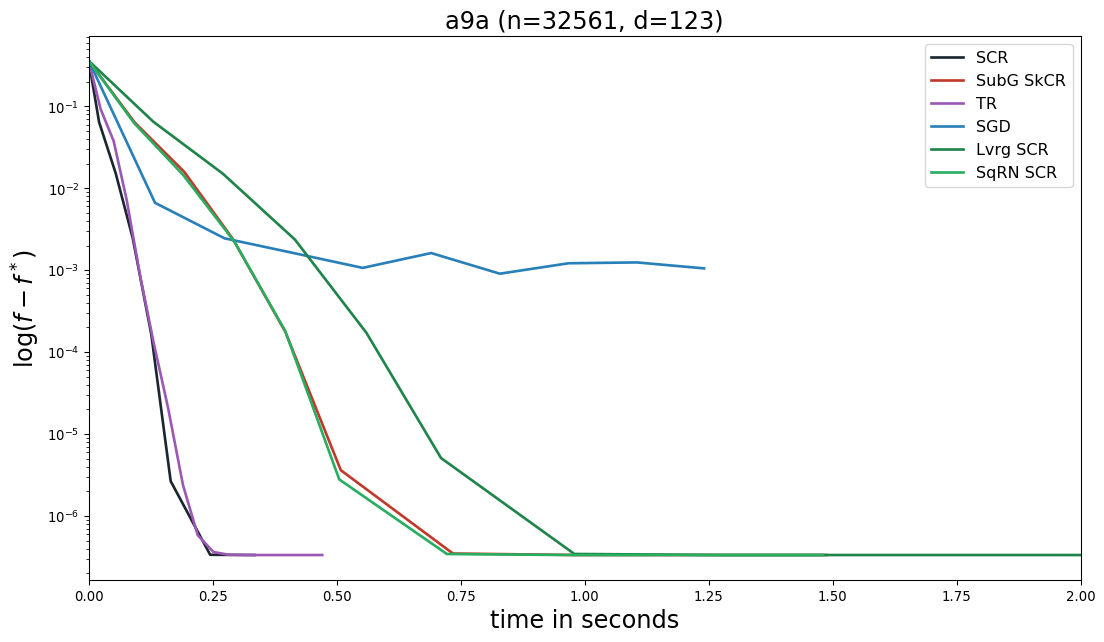

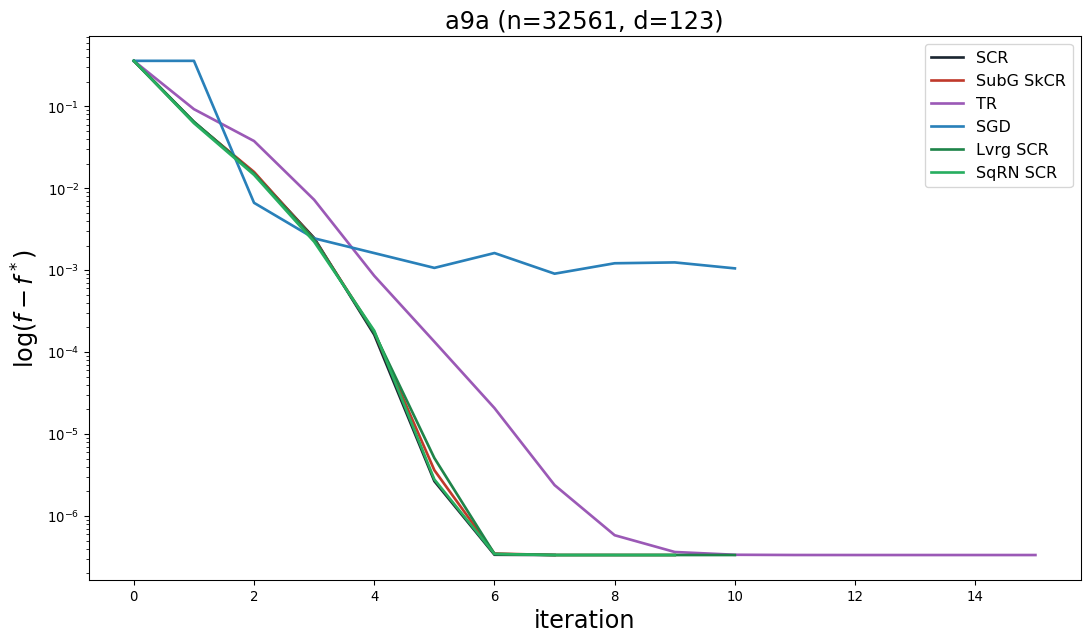

In [6]:
%matplotlib inline
show_plots(x_limits_time=(0,2))